In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import skimage.transform as skt

class MnistDataSet(torch.utils.data.Dataset):
    def __init__(self):
        mnist_train = datasets.MNIST(root='./mnist_data/', train=True, download=True).data
        self.data = mnist_train


    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = skt.resize(self.data[idx], (32, 32))
        return x

dataset = MnistDataSet()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
        print('and then re-execute this cell.')
    else:
        print(gpu_info)
print('device :',device)
print('torch.version :',torch.__version__)

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!





/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Wed Jan  6 06:11:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    12W /  70W |     10MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
def log_likelihood_normal(x, mu, lv):
    nllh2 = np.log(2.0 * np.pi) + lv + ((x - mu)**2)/torch.exp(lv)
    return -0.5 * nllh2

def sample_normal(mu, lv):
    return mu + torch.exp(0.5 * lv) * torch.randn_like(mu)

def KLD_normal(mu1, lv1, mu2, lv2):
    return 0.5 * (lv2 - lv1 + (torch.exp(lv1) + ((mu1 - mu2)**2))/torch.exp(lv2) - 1.0)

In [3]:
# This code is based on https://github.com/NVlabs/NVAE

# NO spectral normalization, No AdaMax optimizer, NO BN momentum change
# Detail architecture, hyperparameters are defferent.
# number of latent variables is very reduced in this model ([1,4,4],[1,8,8],[1,16,16])
class SE(nn.Module):
    def __init__(self, Cin, Cout):
        super(SE, self).__init__()
        num_hidden = max(Cout // 16, 4)
        self.se = nn.Sequential(nn.Linear(Cin, num_hidden), nn.ReLU(), nn.Linear(num_hidden, Cout), nn.Sigmoid())

    def forward(self, x):
        se = torch.mean(x, dim=[2, 3])
        se = se.view(se.size(0), -1)
        se = self.se(se)
        se = se.view(se.size(0), -1, 1, 1)
        return x * se


class WNConv2d(nn.Conv2d):
    def __init__(self, C_in, C_out, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=False):
        super(WNConv2d, self).__init__(C_in, C_out, kernel_size, stride, padding, dilation, groups, bias)
        init = torch.sqrt(self.weight.pow(2).sum(dim=[1, 2, 3])).view(-1, 1, 1, 1)
        self.log_weight_norm = nn.Parameter(torch.log(init + 1e-2), requires_grad=True)

    def forward(self, x):
        wn = torch.sqrt(torch.sum(self.weight * self.weight, dim=[1, 2, 3]))
        wn = torch.exp(self.log_weight_norm) * self.weight / (wn.view(-1, 1, 1, 1) + 1e-5)
        return F.conv2d(x, wn, self.bias, self.stride, self.padding, self.dilation, self.groups)


class FactorizedReduce(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.conv_1 = WNConv2d(cin, cout // 4, 1, stride=2, padding=0, bias=True)
        self.conv_2 = WNConv2d(cin, cout // 4, 1, stride=2, padding=0, bias=True)
        self.conv_3 = WNConv2d(cin, cout // 4, 1, stride=2, padding=0, bias=True)
        self.conv_4 = WNConv2d(cin, cout - 3 * (cout // 4), 1, stride=2, padding=0, bias=True)

    def forward(self, x):
        out = x * torch.sigmoid(x)
        conv1 = self.conv_1(out)
        conv2 = self.conv_2(out[:, :, 1:, 1:])
        conv3 = self.conv_3(out[:, :, :, 1:])
        conv4 = self.conv_4(out[:, :, 1:, :])
        out = torch.cat([conv1, conv2, conv3, conv4], dim=1)
        return out


class EncoderResidualCell(nn.Module):
    def __init__(self, cin, cout, bias=True):
        super().__init__()
        self.conv1 = nn.Sequential(nn.BatchNorm2d(cin), nn.Conv2d(cin, cout, 3, stride=1, padding=1, bias=bias))
        self.conv2 = nn.Sequential(nn.BatchNorm2d(cout), nn.Conv2d(cout, cout, 3, stride=1, padding=1, bias=bias))
        self.skip = WNConv2d(cin, cout, 1, stride=1, padding=0, bias=bias)
        self.se = SE(cout, cout)

    def forward(self, x):
        f = self.conv1(x * torch.sigmoid(x))
        f = self.conv2(f * torch.sigmoid(f))
        return self.skip(x) + 0.5 * self.se(f)


class EncoderDownsampleResidualCell(nn.Module):
    def __init__(self, cin, cout, bias=True):
        super().__init__()
        self.down = nn.AvgPool2d(kernel_size=(2, 2))
        self.conv1 = nn.Sequential(nn.BatchNorm2d(cin), nn.Conv2d(cin, cout, 3, stride=1, padding=1, bias=bias))
        self.conv2 = nn.Sequential(nn.BatchNorm2d(cout), nn.Conv2d(cout, cout, 3, stride=1, padding=1, bias=bias))
        self.skip = FactorizedReduce(cin, cout)
        self.se = SE(cout, cout)

    def forward(self, x):
        f = self.down(x)
        f = self.conv1(f * torch.sigmoid(f))
        f = self.conv2(f * torch.sigmoid(f))
        return self.skip(x) + 0.5 * self.se(f)


class EncCombiner(nn.Module):
    def __init__(self, cin_left, cin_right, cout):
        super().__init__()
        assert cin_left == cout
        self.net = WNConv2d(cin_right, cout, 1, 1, 0, bias=True)

    def forward(self, s, z):
        return s + self.net(z)

    
class DecCombiner(nn.Module):
    def __init__(self, cin_left, cin_right, cout):
        super().__init__()
        self.net = WNConv2d(cin_left + cin_right, cout, 1, 1, 0, bias=True)

    def forward(self, s, z): #여기서 s에 비해 z의 비중이 너무 작아 모델이 불안정한것 같다.
        return self.net(torch.cat([s, z], dim=1))


class Sampler(nn.Module):
    def __init__(self, cin, cout):
        super().__init__()
        self.net = WNConv2d(cin, 2 * cout, 1, 1, 0, bias=True)

    def forward(self, x):
        x = self.net(x)
        mu, lv = x.chunk(2, 1)
        return mu, lv

# i refered to https://github.com/kartikeya-badola/NVAE-PyTorch for the DepsepConv2d
class DepsepConv2d(nn.Module):
    def __init__(self, nin, kernels_per_layer, nout):
        super(DepsepConv2d, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=5, padding=2, groups=nin)
        self.pointwise = nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


class DecoderResidualCell(nn.Module):
    def __init__(self, cin, cout, bias=True):
        super().__init__()
        self.conv1 = nn.Sequential(nn.BatchNorm2d(cin), nn.Conv2d(cin, cout, 1, stride=1, padding=0, bias=bias))
        self.conv2 = nn.Sequential(nn.BatchNorm2d(cout), DepsepConv2d(cout, 4, cout))
        self.conv3 = nn.Sequential(nn.Conv2d(cout, cout, 1, stride=1, padding=0, bias=bias), nn.BatchNorm2d(cout))
        self.skip = WNConv2d(cin, cout, 1, stride=1, padding=0, bias=bias)
        self.se = SE(cout, cout)

    def forward(self, x):
        f = self.conv1(x * torch.sigmoid(x))
        f = self.conv2(f * torch.sigmoid(f))
        return self.skip(x) + 0.5 * self.se(self.conv3(f))



class DecoderUpsampleResidualCell(nn.Module):
    def __init__(self, cin, cout, bias=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(cin, cout, kernel_size=2, stride=2)
        self.conv1 = nn.Sequential(nn.BatchNorm2d(cout), nn.Conv2d(cout, cout, 1, stride=1, padding=0, bias=bias))
        self.conv2 = nn.Sequential(nn.BatchNorm2d(cout), DepsepConv2d(cout, 4, cout))
        self.conv3 = nn.Sequential(nn.Conv2d(cout, cout, 1, stride=1, padding=0, bias=bias), nn.BatchNorm2d(cout))
        self.skip = nn.ConvTranspose2d(cin, cout, kernel_size=2, stride=2)
        self.se = SE(cout, cout)

    def forward(self, x):
        f = self.up(x)
        f = self.conv1(f * torch.sigmoid(f))
        f = self.conv2(f * torch.sigmoid(f))
        return self.skip(x) + 0.5 * self.se(self.conv3(f))

In [4]:
# mixture of logistic cdf
def discretized_mol_loss(target, logits, mu, logscale): 
    # i refered to https://github.com/kamenbliznashki/pixel_models/blob/master/pixelcnnpp.py 
    # 0<=x<=1, to 8bit
    log_pi = F.log_softmax(logits, dim=1)
    half_border = (1.0/255) * 0.5 # maybe border = [x.max - x.min]/(num_class - 1)
    logscale = torch.clamp(logscale, min=-7.)
    inv_stdv = torch.exp(-logscale)
    right_border = target + half_border - mu
    left_border = target - half_border - mu
    right_cdf = torch.sigmoid(inv_stdv * right_border)
    right_cdf = torch.where(target + half_border <= 0.999, right_cdf, torch.ones(1).to(device))
    left_cdf = torch.sigmoid(inv_stdv * left_border)
    left_cdf = torch.where(0.001 <= target - half_border, left_cdf, torch.zeros(1).to(device))
    log_cdf_delta = torch.log(right_cdf -  left_cdf + 1e-10)
    log_prob = log_pi + log_cdf_delta
    return -log_prob.logsumexp(dim=1)

def discretized_mol_sampling(logits, mu, logscale):
    nb, nc, nh, nw  = logits.size(0), logits.size(1), logits.size(2), logits.size(3)
    logits = logits.permute(0, 2, 3, 1).reshape(-1, nc)
    mu = mu.permute(0, 2, 3, 1).reshape(-1, nc)
    logscale = logscale.permute(0, 2, 3, 1).reshape(-1, nc)

    #gumbel-max sampling for selecting distribution
    y = F.log_softmax(logits, dim=-1) + randg_like(logits)
    index = y.argmax(dim=-1, keepdim=True)

    mu_selected = torch.gather(mu, 1, index)
    logscale_selected = torch.gather(logscale, 1, index)
    u = torch.rand_like(mu_selected)
    logscale_selected = logscale_selected.clamp(-7, 10)

    # inverse-cdf sampling from the selected logistic distribution 
    x = mu_selected + torch.exp(logscale_selected) * torch.log((u/(1-u)) + 1e-10)
    x = x.reshape(nb, nh, nw, 1).permute(0, 3, 1, 2)
    x = x.clamp(0, 1) 
    x = (x * 255).int().float() / 255.0
    return x


class Nvae(nn.Module):
    def __init__(self):
        super().__init__()
        self.stem = WNConv2d(1, 16, 3, 1, 1, bias=True) #(1,32,32)->(16,32,32)
        self.pre_process = nn.Sequential(
            EncoderResidualCell(16, 32),#(16,32,32)->(32,32,32)
            EncoderResidualCell(32, 64) #(32,32,32)->(64,32,32)
        )

        self.enc_tower =  nn.ModuleList([
            nn.Sequential(EncoderResidualCell( 64, 128), EncoderDownsampleResidualCell(128, 128)),  #( 64,32,32)->(128,16,16)
            nn.Sequential(EncoderResidualCell(128, 256), EncoderDownsampleResidualCell(256, 256)), #(128,16,16)->(256, 8, 8)
            nn.Sequential(EncoderResidualCell(256, 512), EncoderDownsampleResidualCell(512, 512))  #(256, 8, 8)->(512, 4, 4)
        ])
                
        self.enc_combiner =  nn.ModuleList([
            EncCombiner(128, 128, 128), #(128,16,16)x(128,16,16)->(128,16,16)
            EncCombiner(256, 256, 256)  #(256, 8, 8)x(256, 8, 8)->(256, 8, 8)
        ])

        self.dec_tower = nn.ModuleList([
            nn.Sequential(DecoderResidualCell(256, 256), DecoderUpsampleResidualCell(256, 128)),
            nn.Sequential(DecoderResidualCell(512, 512), DecoderUpsampleResidualCell(512, 256))      
        ])

        self.dec_combiner =  nn.ModuleList([
            DecCombiner(1, 128, 128), #(1,16,16)x(128,16,16)->(128,16,16)
            DecCombiner(1, 256, 256), #(1, 8, 8)x(256, 8, 8)->(256, 8, 8)
            DecCombiner(1, 512, 512)  #(1, 4, 4)x(512, 4, 4)->(512, 4, 4)
        ])

        self.enc_sampler =  nn.ModuleList([
            Sampler(128, 1), #(128,14,14)->(1,16,16)x(1,16,16)
            Sampler(256, 1), #(256, 8, 8)->(1, 8, 8)x(1, 8, 8)
            Sampler(512, 1)  #(512, 4, 4)->(1, 4, 4)x(1, 4, 4)
        ])

        self.dec_sampler =  nn.ModuleList([
            Sampler(128, 1), #(128,16,16)->(1,16,16)x(1,16,16)
            Sampler(256, 1)  #(256, 8, 8)->(1, 8, 8)x(1, 8, 8)
        ])

        self.post_process = nn.Sequential(
            DecoderUpsampleResidualCell(128, 128),
            DecoderResidualCell(128, 128),     
            DecoderResidualCell(128, 30) # 10-mixture
        )

        self.seed = nn.Parameter(torch.rand(1, 512, 4, 4), requires_grad=True)
        self.res_dist = True

    def forward(self, x):
        s = self.stem(x)
        s = self.pre_process(s)
        bottom_up_s = []
        for cell in self.enc_tower:
            s = cell(s)
            bottom_up_s.append(s)

        mu_z_top_q, lv_z_top_q = self.enc_sampler[-1](bottom_up_s[-1])
        z = sample_normal(mu_z_top_q, lv_z_top_q)
        all_q = [{'mu':mu_z_top_q, 'lv':lv_z_top_q}]
        log_q_conv = log_likelihood_normal(z, mu_z_top_q, lv_z_top_q)

        # apply NF       
        # z_new, logdet = flow[-1](z)
        # log_q_conv -= log_det
        # z = z_new
        
        all_log_q = [log_q_conv]
        mu_z_top_p = torch.zeros_like(z)
        lv_z_top_p = torch.zeros_like(z)
        log_p_conv = log_likelihood_normal(z, mu_z_top_p, lv_z_top_p)
        all_p = [{'mu':mu_z_top_p, 'lv':lv_z_top_p}]
        all_log_p = [log_p_conv]


        s = self.seed.expand(z.size(0), -1, -1, -1)
        s = self.dec_combiner[-1](z, s)

        for level in reversed(range(2)):
   
            s = self.dec_tower[level](s)
            mu_z_p, lv_z_p = self.dec_sampler[level](s)
            m = self.enc_combiner[level](bottom_up_s[level], s)
            mu_z_q, lv_z_q = self.enc_sampler[level](m)
            if self.res_dist:
                mu_z_q = mu_z_q + mu_z_p
                lv_z_q = lv_z_q + lv_z_p
            z = sample_normal(mu_z_q, lv_z_q)
            log_q_conv = log_likelihood_normal(z, mu_z_q, lv_z_q)

            # apply NF
            # z_new, logdet = flow[level](z)
            # log_q_conv -= log_det
            # z = z_new

            all_q.append({'mu':mu_z_q, 'lv':lv_z_q}) 
            log_p_conv = log_likelihood_normal(z, mu_z_p, lv_z_p)
            all_log_p.append(log_p_conv)
            all_p.append({'mu':mu_z_p, 'lv':lv_z_p})
            s = self.dec_combiner[level](z, s)

        s = self.post_process(s)
        logits, mu_x, ls_x = s.chunk(3, 1)
        # log_q, log_p 는 Normalizing flow일때 KL 계산하기 위함
        return logits, mu_x, ls_x, all_log_q, all_log_p, all_q, all_p


    def sample_from_top(self, z): # z.shape = [b,1,4,4]
        s = self.seed.expand(z.size(0), -1, -1, -1)
        s = self.dec_combiner[-1](z, s)

        for level in reversed(range(2)):
   
            s = self.dec_tower[level](s)
            mu_z_p, lv_z_p = self.dec_sampler[level](s)
            z = sample_normal(mu_z_p, lv_z_p)
            s = self.dec_combiner[level](z, s)

        s = self.post_process(s)
        logits, mu_x, ls_x = s.chunk(3, 1)
        return logits, mu_x, ls_x

In [8]:
model = Nvae().to(device)
solver = torch.optim.Adam(model.parameters(), lr=1e-4)
mbsz = 128
loader = DataLoader(dataset, batch_size=mbsz, shuffle=True, drop_last=True)

In [9]:
num_epochs = 30
beta = 0.0
for epoch in range(num_epochs):
    for x in loader:
        if beta < 1.0:
            beta += 0.05 / len(loader)
        else:
            beta = 1.0
        solver.zero_grad()
        x = x.reshape(-1, 1, 32, 32).float().to(device)

        logits, mu_x_p, ls_x_p, all_log_q, all_log_p, all_q, all_p = model(x)

        kld = 0.0
        for q, p in zip(all_q, all_p):
            kl = KLD_normal(q['mu'], q['lv'], p['mu'], p['lv']).sum(dim=[1, 2, 3]).mean()
            kld += kl

        reconstruction = discretized_mol_loss(x, logits, mu_x_p, ls_x_p).mean() * 32 * 32.
        loss = reconstruction + beta * kld
        loss.backward()
        solver.step()
    print('reconstruction : ', reconstruction.item(), 'kld : ', kld.item())


reconstruction :  1100.732666015625 kld :  525.4348754882812
reconstruction :  1001.020263671875 kld :  433.2939147949219
reconstruction :  977.8434448242188 kld :  397.86822509765625
reconstruction :  1011.7708740234375 kld :  369.71075439453125
reconstruction :  1072.8270263671875 kld :  323.539794921875
reconstruction :  978.652587890625 kld :  310.40069580078125
reconstruction :  954.1561889648438 kld :  292.8970642089844
reconstruction :  916.9552001953125 kld :  262.3475341796875
reconstruction :  930.6880493164062 kld :  266.62298583984375
reconstruction :  891.1190795898438 kld :  239.174072265625
reconstruction :  852.2783203125 kld :  224.9207763671875
reconstruction :  887.4869995117188 kld :  213.47950744628906
reconstruction :  859.7427368164062 kld :  203.21163940429688
reconstruction :  896.1751708984375 kld :  205.60546875
reconstruction :  840.569091796875 kld :  190.84173583984375
reconstruction :  920.7828369140625 kld :  197.16024780273438
reconstruction :  783.3646

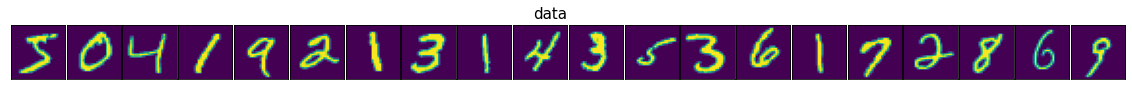

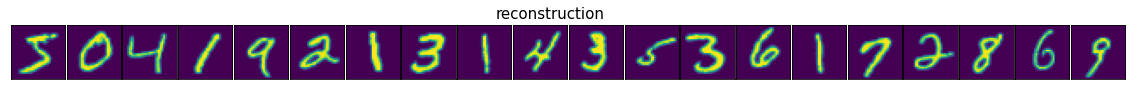

-


In [10]:
def randg_like(tensor):
    return -torch.log(-torch.log(torch.rand_like(tensor) + 1e-10) + 1e-10)
    
num_image = 20

fig = plt.figure(figsize=(20, 2))
n = 0
for i in range(num_image):
    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(dataset.data[n].cpu().reshape(28, 28).numpy())
    n += 1
fig.suptitle('data', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

fig = plt.figure(figsize=(20, 2))
n = 0

model.eval()
for i in range(num_image):

    x = torch.from_numpy(dataset.__getitem__(n)).float().reshape(1, 1, 32, 32).to(device)

    logits, mu_x_p, ls_x_p, all_log_q, all_log_p, all_q, all_p = model(x)
    x_p = discretized_mol_sampling(logits, mu_x_p, ls_x_p).reshape(32, 32).cpu().detach()
    x_p = x_p.detach().cpu()


    _fig = fig.add_subplot(2, num_image, n + 1, xticks=[], yticks=[])
    _fig.imshow(x_p.cpu().data.numpy().reshape(32, 32))
    n += 1
fig.suptitle('reconstruction', y=1.01, fontsize=15)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

model.train()
print('-')